# OrthoMorph — **Multi‑Image Landmark Editor** + Batch Morphing (v9.f)

In [19]:
# === Backend Setup ===
def _try_backend():
    tried = []
    try:
        import ipympl  # noqa: F401
        get_ipython().run_line_magic("matplotlib", "widget")
        print("Using backend: %matplotlib widget")
        return "widget", tried
    except Exception as e:
        tried.append(f"ipympl: {e}")
        try:
            get_ipython().run_line_magic("matplotlib", "notebook")
            print("Using backend: %matplotlib notebook")
            return "notebook", tried
        except Exception as e2:
            tried.append(f"notebook: {e2}")
            try:
                get_ipython().run_line_magic("matplotlib", "inline")
                print("FALLBACK: %matplotlib inline (mouse events disabled)")
                return "inline", tried
            except Exception as e3:
                tried.append(f"inline: {e3}")
                print("Cannot set any backend. Events will not work.")
                return None, tried

_backend, _attempts = _try_backend()
print("Tried:", _attempts)

Using backend: %matplotlib widget
Tried: []


In [20]:
# === Imports & Config ===
import os, json, re, math, datetime
import numpy as np
import cv2
from PIL import Image, ExifTags
from IPython.display import Video, display, HTML
import matplotlib.pyplot as plt
from matplotlib.collections import PathCollection
import ipywidgets as widgets
from dataclasses import dataclass

try:
    from scipy.spatial import Delaunay as SciPyDelaunay
    SCIPY_AVAILABLE = True
except Exception:
    SCIPY_AVAILABLE = False

def ensure_dir(p):
    os.makedirs(p, exist_ok=True)
    return p

IMG_DIR = "img"
COMMON_SIZE = (640, 480)
OUT_DIR = ensure_dir("out_orthomorph")
FPS = 30
STEPS_PER_PAIR = 50
AUTO_BOUNDARY = True
BOUNDARY_MARGIN = 0
MULTI_JSON = "points_multi.json"
SORT_MODE = "exif"

In [21]:
# === Utils (I/O, EXIF, sorting) ===
def imread_rgb(path):
    import cv2
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    if img is None:
        raise FileNotFoundError(path)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def list_images_sorted(img_dir, mode="exif"):
    def natural_key(s):
        import re as _re
        return [int(text) if text.isdigit() else text.lower() for text in _re.split(r'(\d+)', s)]
    def get_exif_datetime(path):
        try:
            from PIL import Image, ExifTags
            import datetime as _dt
            with Image.open(path) as im:
                exif = im._getexif() or {}
                tag_map = {ExifTags.TAGS.get(k, k): v for k, v in exif.items()}
                for key in ("DateTimeOriginal", "DateTimeDigitized", "DateTime"):
                    if key in tag_map:
                        txt = tag_map[key]
                        if isinstance(txt, bytes):
                            txt = txt.decode("utf-8", "ignore")
                        try:
                            return _dt.datetime.strptime(txt.strip(), "%Y:%m:%d %H:%M:%S")
                        except Exception:
                            pass
        except Exception:
            pass
        try:
            import datetime as _dt
            return _dt.datetime.fromtimestamp(os.path.getmtime(path))
        except Exception:
            import datetime as _dt
            return _dt.datetime(1970, 1, 1)
    exts = (".jpg", ".jpeg", ".png", ".bmp", ".JPG", ".JPEG", ".PNG", ".BMP")
    files = [os.path.join(img_dir, f) for f in os.listdir(img_dir) if f.endswith(exts)]
    if mode == "name":
        files.sort(key=lambda p: natural_key(os.path.basename(p)))
    else:
        files.sort(key=lambda p: (get_exif_datetime(p), natural_key(os.path.basename(p))))
    return files

def prepare_images_list(files, common_size):
    import cv2
    imgs = []
    for i, p in enumerate(files):
        im = imread_rgb(p)
        if common_size is not None:
            im = cv2.resize(im, common_size, interpolation=cv2.INTER_AREA)
        elif i > 0:
            h, w = imgs[0].shape[:2]
            im = cv2.resize(im, (w, h), interpolation=cv2.INTER_AREA)
        imgs.append(im)
    return imgs

In [22]:
# === Morph core ===
import numpy as np
import cv2

def apply_affine_transform(src, src_tri, dst_tri, size):
    warp_mat = cv2.getAffineTransform(np.float32(src_tri), np.float32(dst_tri))
    return cv2.warpAffine(src, warp_mat, (size[0], size[1]), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101)

def rect_contains(rect, point):
    x, y, w, h = rect
    return (x <= point[0] < x + w) and (y <= point[1] < y + h)

def warp_triangle(img, img_warp, t_src, t_dst):
    r1 = cv2.boundingRect(np.float32([t_src]))
    r2 = cv2.boundingRect(np.float32([t_dst]))
    t1_rect = [((t_src[i][0] - r1[0]), (t_src[i][1] - r1[1])) for i in range(3)]
    t2_rect = [((t_dst[i][0] - r2[0]), (t_dst[i][1] - r2[1])) for i in range(3)]
    mask = np.zeros((r2[3], r2[2], 3), dtype=np.float32)
    cv2.fillConvexPoly(mask, np.int32([t2_rect]), (1.0, 1.0, 1.0))
    img1_rect = img[r1[1]:r1[1]+r1[3], r1[0]:r1[0]+r1[2]]
    size = (r2[2], r2[3])
    warp = apply_affine_transform(img1_rect, t1_rect, t2_rect, size)
    img_warp[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] = img_warp[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] * (1 - mask) + warp * mask

def add_boundary_points(points, w, h, margin=0):
    m = margin
    pts = list(points)
    pts += [(0+m,0+m),(w-1-m,0+m),(w-1-m,h-1-m),(0+m,h-1-m)]
    pts += [(w//2,0+m),(w//2,h-1-m),(0+m,h//2),(w-1-m,h//2)]
    return pts

def delaunay_tris(points, w, h):
    pts = np.array(points, dtype=np.float32)
    try:
        from scipy.spatial import Delaunay as SciPyDelaunay
        if len(pts) >= 3:
            tri = SciPyDelaunay(pts)
            return tri.simplices.tolist()
    except Exception:
        pass
    rect = (0, 0, w, h)
    subdiv = cv2.Subdiv2D(rect)
    for p in pts:
        subdiv.insert((float(p[0]), float(p[1])))
    triangle_list = subdiv.getTriangleList()
    triangles = []
    for t in triangle_list:
        x1,y1,x2,y2,x3,y3 = t
        p1=(x1,y1); p2=(x2,y2); p3=(x3,y3)
        if rect_contains((0,0,w,h),p1) and rect_contains((0,0,w,h),p2) and rect_contains((0,0,w,h),p3):
            def nearest_idx(pt):
                d = np.sum((pts-pt)**2, axis=1)
                return int(np.argmin(d))
            tri_idx = sorted(list({nearest_idx(p1),nearest_idx(p2),nearest_idx(p3)}))
            if len(tri_idx) == 3:
                triangles.append(tri_idx)
    uniq, seen = [], set()
    for a,b,c in triangles:
        key = tuple(sorted((a,b,c)))
        if key not in seen:
            seen.add(key); uniq.append([a,b,c])
    return uniq

def morph_images(imgA, imgB, ptsA, ptsB, alpha, triangles=None, add_boundary=True, boundary_margin=0):
    h, w = imgA.shape[:2]
    assert imgB.shape[:2] == (h, w)
    assert len(ptsA) == len(ptsB) and len(ptsA) >= 3
    A = [tuple(map(float,p)) for p in ptsA]
    B = [tuple(map(float,p)) for p in ptsB]
    if add_boundary:
        A = add_boundary_points(A, w, h, boundary_margin)
        B = add_boundary_points(B, w, h, boundary_margin)
    P = [((1-alpha)*A[i][0] + alpha*B[i][0], (1-alpha)*A[i][1] + alpha*B[i][1]) for i in range(len(A))]
    if triangles is None:
        triangles = delaunay_tris(P, w, h)
    out = np.zeros_like(imgA, dtype=np.float32)
    for tri in triangles:
        x,y,z = tri
        t  = [P[x], P[y], P[z]]
        tA = [A[x], A[y], A[z]]
        tB = [B[x], B[y], B[z]]
        tmpA = out.copy(); tmpB = out.copy()
        warp_triangle(imgA, tmpA, tA, t)
        warp_triangle(imgB, tmpB, tB, t)
        out = (1 - alpha) * tmpA + alpha * tmpB
    return np.clip(out,0,255).astype(np.uint8), triangles

def append_transition_to_writer(writer, imgA, imgB, ptsA, ptsB, n_steps, drop_first_frame, per_progress=None):
    h,w = imgA.shape[:2]
    mid = [((ptsA[i][0]+ptsB[i][0])/2.0, (ptsA[i][1]+ptsB[i][1])/2.0) for i in range(len(ptsA))]
    mid = add_boundary_points(mid, w, h, BOUNDARY_MARGIN) if AUTO_BOUNDARY else mid
    tris = delaunay_tris(mid, w, h)
    alphas = np.linspace(0, 1, n_steps)
    if drop_first_frame:
        alphas = alphas[1:]
    if per_progress is not None:
        per_progress.max = len(alphas)
        per_progress.value = 0
    for k in alphas:
        frame, _ = morph_images(imgA, imgB, ptsA, ptsB, alpha=float(k), triangles=tris,
                                add_boundary=AUTO_BOUNDARY, boundary_margin=BOUNDARY_MARGIN)
        writer.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))
        if per_progress is not None:
            per_progress.value += 1
    return len(alphas)

Output()

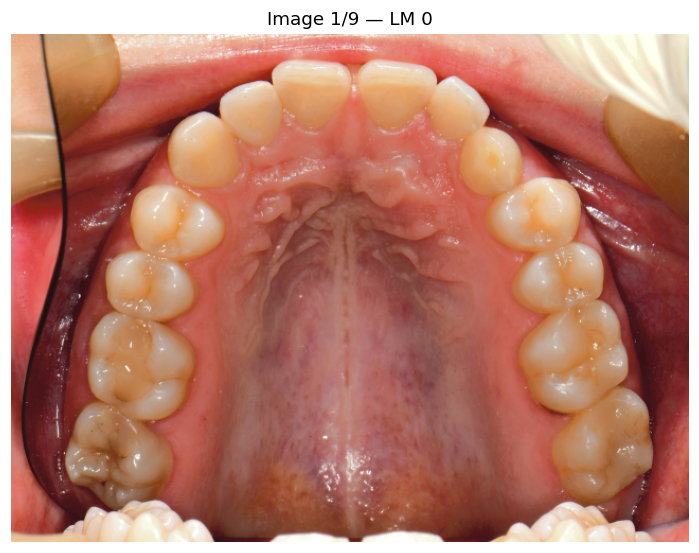

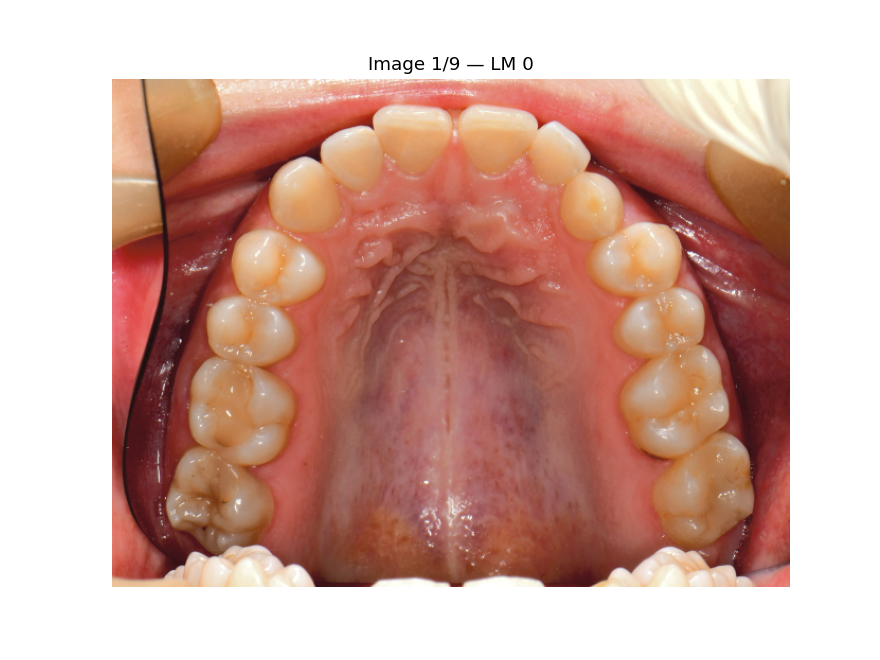

In [23]:
# === Multi‑Image Landmark Editor (auto‑advance) ===
from dataclasses import dataclass
import matplotlib.pyplot as plt
import ipywidgets as widgets
from matplotlib.collections import PathCollection
import numpy as np, math, os

@dataclass
class MultiState:
    img_paths: list = None
    images: list = None
    points: list = None   # per image: list[(x,y) | None]
    current_image: int = 0
    current_landmark: int = 0
    drag_mode: bool = False
    selected_idx: int = -1
    scatter: PathCollection = None

ms = MultiState(img_paths=[], images=[], points=[])

def ensure_landmark(idx):
    for i in range(len(ms.points)):
        while len(ms.points[i]) <= idx:
            ms.points[i].append(None)

def set_point(img_idx, lm_idx, xy):
    ensure_landmark(lm_idx)
    ms.points[img_idx][lm_idx] = (float(xy[0]), float(xy[1]))

def get_point(img_idx, lm_idx):
    ensure_landmark(lm_idx)
    return ms.points[img_idx][lm_idx]

def load_all(sort_mode="exif"):
    files = list_images_sorted(IMG_DIR, mode=sort_mode)
    if not files:
        raise RuntimeError(f"No images in {IMG_DIR}")
    imgs = prepare_images_list(files, COMMON_SIZE)
    ms.img_paths = files
    ms.images = imgs
    if not ms.points or len(ms.points) != len(imgs):
        ms.points = [[] for _ in imgs]
    ms.current_image = 0
    ms.current_landmark = 0

# Widgets
sort_dropdown = widgets.Dropdown(options=[("EXIF date","exif"),("A–Z name","name")], value=SORT_MODE, description="Sort:")
btn_reload = widgets.Button(description="Reload", button_style="info")
btn_prev_img = widgets.Button(description="⟨ Prev image")
btn_next_img = widgets.Button(description="Next image ⟩")
btn_prev_lm = widgets.Button(description="« Prev LM")
btn_next_lm = widgets.Button(description="Next LM »", button_style="primary")
btn_delete = widgets.Button(description="Delete current LM", button_style="warning")
btn_copy_prev = widgets.Button(description="Copy LM from prev image")
toggle_drag = widgets.ToggleButton(value=False, description="Drag Mode", icon="arrows")
chk_auto_img = widgets.Checkbox(value=True, description="Auto next image")
chk_auto_lm = widgets.Checkbox(value=True, description="Auto next landmark when complete")
btn_save = widgets.Button(description="💾 Save multi JSON", button_style="success")
btn_load = widgets.Button(description="📂 Load multi JSON")
status = widgets.Output()

fig, ax = plt.subplots(1,1, figsize=(8,6), dpi=110)

def draw_current():
    ax.clear()
    im = ms.images[ms.current_image]
    with plt.ioff():
        ax.imshow(im)
    ax.set_title(f"Image {ms.current_image+1}/{len(ms.images)} — LM {ms.current_landmark}")
    pts = ms.points[ms.current_image] if ms.points else []
    X, Y = [], []
    for p in pts:
        if p is not None:
            X.append(p[0]); Y.append(p[1])
    ms.scatter = ax.scatter(X, Y, s=36, marker='o')
    ensure_landmark(ms.current_landmark)
    cur = ms.points[ms.current_image][ms.current_landmark]
    if cur is not None:
        ax.scatter([cur[0]],[cur[1]], s=90, marker='o', facecolors='none', edgecolors='yellow', linewidths=2)
        ax.text(cur[0]+4, cur[1]+4, f"LM {ms.current_landmark}", color='yellow', fontsize=9)
    ax.set_axis_off()
    fig.canvas.draw_idle()

def nearest_idx(xy, maxd=20):
    pts = ms.points[ms.current_image]
    cands = [(j,p) for j,p in enumerate(pts) if p is not None]
    if not cands:
        return None
    d = [math.hypot(xy[0]-p[0], xy[1]-p[1]) for j,p in cands]
    k = int(np.argmin(d))
    return cands[k][0] if d[k] <= maxd else None

def is_landmark_complete(lm_idx):
    ensure_landmark(lm_idx)
    for i in range(len(ms.images)):
        if len(ms.points[i]) <= lm_idx or ms.points[i][lm_idx] is None:
            return False
    return True

def next_image_needing_lm(start_img, lm_idx):
    for i in range(start_img+1, len(ms.images)):
        ensure_landmark(lm_idx)
        if len(ms.points[i]) <= lm_idx or ms.points[i][lm_idx] is None:
            return i
    return None

def first_image_needing_lm(lm_idx):
    for i in range(len(ms.images)):
        ensure_landmark(lm_idx)
        if len(ms.points[i]) <= lm_idx or ms.points[i][lm_idx] is None:
            return i
    return None

def advance_after_set():
    if chk_auto_img.value:
        i_next = next_image_needing_lm(ms.current_image, ms.current_landmark)
        if i_next is not None:
            ms.current_image = i_next
            draw_current()
            return
    if chk_auto_lm.value and is_landmark_complete(ms.current_landmark):
        ms.current_landmark += 1
        ensure_landmark(ms.current_landmark)
        i0 = first_image_needing_lm(ms.current_landmark)
        ms.current_image = i0 if i0 is not None else 0
        with status:
            print(f"→ Landmark {ms.current_landmark} started.")
        draw_current()

def on_click(ev):
    if ev.inaxes is not ax or ev.xdata is None or ev.ydata is None:
        return
    x, y = float(ev.xdata), float(ev.ydata)
    if ms.drag_mode:
        j = nearest_idx((x, y))
        if j is not None:
            ms.selected_idx = j
            with status:
                print(f"Selected LM {j} — drag to move")
        return
    set_point(ms.current_image, ms.current_landmark, (x, y))
    draw_current()
    advance_after_set()
    with status:
        pass # print(f"Set LM {ms.current_landmark} @ image {ms.current_image+1}")

def on_motion(ev):
    if not ms.drag_mode or ms.selected_idx == -1:
        return
    if ev.inaxes is not ax or ev.xdata is None or ev.ydata is None:
        return
    x, y = float(ev.xdata), float(ev.ydata)
    set_point(ms.current_image, ms.selected_idx, (x, y))
    draw_current()

def on_release(ev):
    if ms.drag_mode and ms.selected_idx != -1:
        ms.selected_idx = -1

def on_key(ev):
    if ev.key in ('right','n'):
        on_next_img(None)
    elif ev.key in ('left','p'):
        on_prev_img(None)
    elif ev.key in ('m',):
        on_next_lm(None)
    elif ev.key in ('d','backspace'):
        on_delete(None)

def on_prev_img(b):
    ms.current_image = max(0, ms.current_image-1)
    draw_current()

def on_next_img(b):
    ms.current_image = min(len(ms.images)-1, ms.current_image+1)
    draw_current()

def on_prev_lm(b):
    ms.current_landmark = max(0, ms.current_landmark-1)
    draw_current()

def on_next_lm(b):
    ms.current_landmark += 1
    ensure_landmark(ms.current_landmark)
    draw_current()
    with status:
        print(f"→ Now setting LM {ms.current_landmark} across images")

def on_delete(b):
    ensure_landmark(ms.current_landmark)
    ms.points[ms.current_image][ms.current_landmark] = None
    draw_current()

def on_copy_prev(b):
    i, j = ms.current_image, ms.current_landmark
    if i-1 >= 0:
        ensure_landmark(j)
        prev = ms.points[i-1][j] if len(ms.points[i-1])>j else None
        if prev is not None:
            ms.points[i][j] = prev
            draw_current()

def on_toggle_drag(ch):
    ms.drag_mode = ch['new']

def on_reload(b):
    load_all(sort_dropdown.value)
    draw_current()
    with status:
        print(f"Loaded {len(ms.images)} images; sorted by: {sort_dropdown.value}")
        for k, p in enumerate(ms.img_paths):
            print(f"{k+1:02d}: {os.path.basename(p)}")

def save_multi(path="points_multi.json"):
    data = {"img_paths": ms.img_paths, "common_size": COMMON_SIZE, "points": ms.points}
    with open(path, "w", encoding="utf-8") as f:
        json.dump(data, f, ensure_ascii=False, indent=2)
    with status:
        print(f"Saved: {path}")

def load_multi(path="points_multi.json"):
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)
    ms.img_paths = data.get("img_paths", [])
    ms.points = data.get("points", [])
    ms.images = prepare_images_list(ms.img_paths, COMMON_SIZE)
    ms.current_image = 0
    ms.current_landmark = 0
    draw_current()
    with status:
        print(f"Loaded: {path}; images={len(ms.images)}")

# Bindings
btn_prev_img.on_click(on_prev_img); btn_next_img.on_click(on_next_img)
btn_prev_lm.on_click(on_prev_lm); btn_next_lm.on_click(on_next_lm)
btn_delete.on_click(on_delete); btn_copy_prev.on_click(on_copy_prev)
toggle_drag.observe(on_toggle_drag, names='value')
btn_reload.on_click(on_reload)
btn_save.on_click(lambda b: save_multi())
btn_load.on_click(lambda b: load_multi())

# Events
fig.canvas.mpl_connect('button_press_event', on_click)
fig.canvas.mpl_connect('motion_notify_event', on_motion)
fig.canvas.mpl_connect('button_release_event', on_release)
fig.canvas.mpl_connect('key_press_event', on_key)

# First load
load_all(SORT_MODE); draw_current()

# UI layout
toolbar1 = widgets.HBox([sort_dropdown, btn_reload, toggle_drag, chk_auto_img, chk_auto_lm])
toolbar2 = widgets.HBox([btn_prev_img, btn_next_img, btn_prev_lm, btn_next_lm])
toolbar3 = widgets.HBox([btn_delete, btn_copy_prev, btn_save, btn_load])
display(toolbar1, toolbar2, toolbar3, status)
display(fig)

## Build batch video from multi‑image points (with progress bars)

In [24]:
# === Batch builder from multi‑points (robust writer + sanitize points + progress bars) ===
import os
import numpy as np
import cv2
import ipywidgets as widgets
from IPython.display import Video, display, HTML

def _open_video_writer(base_out_no_ext, w, h, fps=30):
    """
    Try multiple containers/codecs and return an opened cv2.VideoWriter plus path and fourcc tag.
    """
    candidates = [("mp4","mp4v"),("mp4","avc1"),("avi","XVID"),("avi","MJPG"),("mkv","X264")]
    for ext, four in candidates:
        out_path = base_out_no_ext + "." + ext
        fourcc = cv2.VideoWriter_fourcc(*four)
        vw = cv2.VideoWriter(out_path, fourcc, float(fps), (int(w), int(h)))
        if vw.isOpened():
            print(f"[VideoWriter] Using codec {four} -> {os.path.basename(out_path)}")
            return vw, out_path, four
    # if we got here, none opened
    raise RuntimeError("Cannot open any VideoWriter. Install ffmpeg/codecs or change candidates list.")

def _to_bgr(img):
    # ensure BGR for VideoWriter
    if img.ndim == 2:
        return cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    if img.shape[2] == 4:
        return cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)
    return cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

def count_valid_pairs(ptsA, ptsB):
    return sum(1 for a,b in zip(ptsA, ptsB) if (a is not None and b is not None))

def have_enough_points(ptsA, ptsB):
    return count_valid_pairs(ptsA, ptsB) >= 3

def fill_missing(ptsA, ptsB, strategy, prev_pts=None, next_pts=None):
    A = list(ptsA); B = list(ptsB); n = min(len(A), len(B))
    for i in range(n):
        if A[i] is None or B[i] is None:
            if strategy == "copy_prev" and prev_pts is not None and i < len(prev_pts) and prev_pts[i] is not None:
                if A[i] is None: A[i] = prev_pts[i]
                if B[i] is None: B[i] = prev_pts[i]
            elif strategy == "copy_next" and next_pts is not None and i < len(next_pts) and next_pts[i] is not None:
                if A[i] is None: A[i] = next_pts[i]
                if B[i] is None: B[i] = next_pts[i]
            # else keep None (skip later)
    return A, B

# Defaults & controls
BATCH_BASENAME = os.path.join(OUT_DIR, "orthomorph_batch_multi")
FILL_STRATEGY = "skip"     # "skip" | "copy_prev" | "copy_next"
DROP_FIRST_FRAME = True

def build_batch_from_multi():
    # Preconditions
    assert ms.images and len(ms.images) >= 2, "Need at least 2 images"
    assert ms.points and len(ms.points) == len(ms.images), "Points length must match images"
    h, w = ms.images[0].shape[:2]
    for im in ms.images:
        assert im.shape[:2] == (h, w), "All images must have same size. (Use COMMON_SIZE loader.)"
    # Steps per pair decision
    total_pairs = max(0, len(ms.images) - 1)
    _use_total = ('w_use_total' in globals()) and bool(w_use_total.value)
    _total_s = float(w_total_sec.value) if ('w_total_sec' in globals()) else 0.0
    _final_still_s = float(w_final_sec.value) if ('w_final_sec' in globals()) else 0.0
    desired_main_frames = int(round(max(0.0, (_total_s - _final_still_s)) * FPS)) if _use_total else None
    if _use_total and desired_main_frames and total_pairs > 0:
        # distribute frames across pairs (dropping first frame within each)
        target_steps_sum = desired_main_frames + (total_pairs - 1 if DROP_FIRST_FRAME else 0)
        base = max(1, target_steps_sum // total_pairs)
        rem = target_steps_sum - base * total_pairs
        steps_list = [base + (1 if i < rem else 0) for i in range(total_pairs)]
    else:
        steps_list = [int(STEPS_PER_PAIR)] * total_pairs
    final_still_frames = int(round(max(0.0, _final_still_s) * FPS))

    # UI progress
    pb_total = widgets.IntProgress(min=0, max=total_pairs, value=0, description='Pairs:')
    pb_frames = widgets.IntProgress(min=0, max=(steps_list[0] if total_pairs>0 else 0), value=0, description='Frames:')
    lbl = widgets.HTML(value='<b>Start</b>')
    display(widgets.VBox([pb_total, pb_frames, lbl]))

    writer, used_path, used_four = _open_video_writer(BATCH_BASENAME, w, h, fps=FPS)

    total_written = 0
    try:
        for i in range(total_pairs):
            imgA = ms.images[i]
            imgB = ms.images[i+1]
            ptsA = ms.points[i]
            ptsB = ms.points[i+1]
            # Fill/skip strategy
            if FILL_STRATEGY == "skip":
                # keep only indices with both points
                keep = [k for k,(a,b) in enumerate(zip(ptsA,ptsB)) if a is not None and b is not None]
                ptsA_use = [ptsA[k] for k in keep]
                ptsB_use = [ptsB[k] for k in keep]
            else:
                prev_pts = ms.points[i-1] if i-1 >= 0 else None
                next_pts = ms.points[i+2] if i+2 < len(ms.points) else None
                ptsA_use, ptsB_use = fill_missing(ptsA, ptsB, FILL_STRATEGY, prev_pts, next_pts)
                # filter any remaining None
                idx = [j for j,(a,b) in enumerate(zip(ptsA_use, ptsB_use)) if a is not None and b is not None]
                ptsA_use = [ptsA_use[j] for j in idx]
                ptsB_use = [ptsB_use[j] for j in idx]

            if len(ptsA_use) < 3:
                lbl.value = f"<span style='color:#c00'>Skip pair {i+1}: not enough common points</span>"
                pb_total.value += 1
                continue

            pb_frames.max = steps_list[i] - (1 if DROP_FIRST_FRAME and steps_list[i] > 0 else 0)
            pb_frames.value = 0
            lbl.value = f"Pair {i+1}/{total_pairs}: {len(ptsA_use)} points, {steps_list[i]} steps"
            total_written += append_transition_to_writer(
                writer,
                imgA, imgB, ptsA_use, ptsB_use,
                n_steps=steps_list[i],
                drop_first_frame=DROP_FIRST_FRAME,
                per_progress=pb_frames
            )
            pb_total.value += 1

        # Append final still frames
        if final_still_frames > 0 and len(ms.images) > 0:
            last = _to_bgr(ms.images[-1])
            for _ in range(int(final_still_frames)):
                writer.write(last)
                total_written += 1
    finally:
        writer.release()

    lbl.value = f"<b>Done.</b> Wrote {int(total_written)} frames to <code>{os.path.basename(used_path)}</code> using <code>{used_four}</code>."
    # Show result
    ext = os.path.splitext(used_path)[1].lower()
    if ext == ".mp4":
        display(Video(used_path, embed=True))
    else:
        display(HTML(f'<a href="{used_path}" download>Download video ({ext[1:].upper()})</a>'))

# --- Duration controls (optional) ---
try:
    w_use_total
    w_total_sec
    w_final_sec
except NameError:
    w_use_total = widgets.Checkbox(description="Use total duration", value=False, indent=False)
    w_total_sec = widgets.FloatText(description="Total duration (s)", value=0.0)
    w_final_sec = widgets.FloatText(description="Final still (s)", value=0.0)
display(widgets.HBox([w_use_total, w_total_sec, w_final_sec]))

btn_build = widgets.Button(description="▶ Build batch video", button_style="primary")
btn_build.on_click(lambda b: build_batch_from_multi())
display(btn_build)

Button(button_style='primary', description='▶ Build batch video', style=ButtonStyle())